In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import utils as ut
import policy_time as pt

In [6]:
fnames = [f'./Data/03_29_3/traj{i}.pkl'for i in range(10)]
traj = ut.make_df(fnames,reward_ahead=1)

In [205]:
trajoff = traj[traj['prev_actions']==0].sample(4000)
trajon = traj[traj['prev_actions']==0].sample(4000)

In [206]:
len(traj)

8635

In [207]:
trajon

,t,obs_b,obs_h,prev_actions,next_obs_b,next_obs_h,reward,loc
5454,153.594,120,0,0,120,30,-0.316789,"[1022.9746835474084, 1352.7594936564742]"
7079,86.078,120,-30,0,120,-30,-0.575862,"[776.0333333385606, 1412.9999999893682]"
338,60.750,-180,0,0,-180,-30,-0.595850,"[1025.1379310380382, 927.1551724172775]"
4682,15.265,-60,-30,0,-60,-30,0.673035,"[940.316326539604, 1275.3061224457913]"
4731,23.984,-60,30,0,-60,0,0.065911,"[923.9021739106977, 1233.9782608514206]"
...,...,...,...,...,...,...,...,...
5596,178.937,30,-30,0,30,-30,0.069281,"[972.5777777709261, 1467.9333333281945]"
5108,91.578,60,-60,0,60,-60,0.318577,"[1048.8139534888896, 1334.5465116486394]"
5711,20.109,120,30,0,120,60,-0.619645,"[901.8611110982828, 1274.597222213593]"
7285,122.890,120,-30,0,120,-30,-1.051546,"[660.0000000100722, 1301.4526315702535]"


Goal is to get a vector for each state: mean reward with standard deviations as timescale increases.

In [13]:
def get_future_rews(traj_type,traj,ahead):
    counts = np.zeros((12,12))
    rews = [[[] for _ in range(12)] for _ in range(12)]
    for i,b in enumerate(np.arange(-180,180,30)):
        for j,h in enumerate(np.arange(-180,180,30)):
            for row in traj_type.iterrows():
                if (row[1]['obs_b']==b) & (row[1]['obs_h']==h):
                    if row[0]<len(traj)-ahead:
                        rvec = traj['reward'][row[0]:row[0]+ahead].to_numpy()
                        rews[i][j].append(rvec)
                        counts[i,j] += 1
            rews[i][j] = np.array(rews[i][j],dtype=object).flatten().reshape(-1,ahead)

    rew_mu = np.zeros((12,12,ahead))
    rew_sig = np.zeros((12,12,ahead))
    for i in range(12):
        for j in range(12):
            if rews[i][j].size > 0:
                rew_mu[i,j,:] = np.mean(rews[i][j].astype(float),axis=0)
                rew_sig[i,j,:] = np.std(rews[i][j].astype(float),axis=0)/np.sqrt(rews[i][j].shape[0])
    counts = np.repeat(np.expand_dims(counts,2),ahead,axis=2)
    rew_mu = np.multiply(rew_mu,counts/np.sum(counts))

    return rew_mu,counts

def weight_mus(mus,counts,ahead):
    mul = []
    for i in range(12):
        for j in range(12):
            if counts[i,j,0] != 0:
                mul.append(mus[i,j,:])
    mul = np.array(mul).flatten().reshape(-1,ahead)
    mul = np.mean(mul,axis=0)    
    return mul

def get_reward_abs(traj, prev_acts=3, ahead=100):
    
    muoffs = []
    muons = []
    
    for i in range(10):
        trajon = traj[traj['prev_actions']==3].sample(100)
        muon,countson = get_future_rews(trajon,traj,ahead)
        muons.append(weight_mus(muon,countson,ahead))
        
        trajoff = traj[traj['prev_actions']==0].sample(len(trajon))
        muoff,countsoff = get_future_rews(trajoff,traj,ahead)
        muoffs.append(weight_mus(muoff,countsoff,ahead))
    
    return np.mean(np.array(muons),axis=0),np.mean(np.array(muoffs),axis=0)

In [14]:
muons,muoffs = get_reward_abs(traj,ahead=500)

KeyboardInterrupt: 

In [9]:
muoffs = np.mean(np.array(muoffs),axis=0)
muons = np.mean(np.array(muons),axis=0)

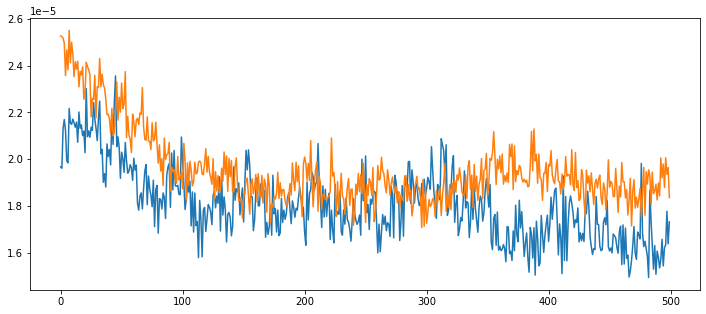

In [10]:
plt.figure(figsize=(12,5))
plt.plot(muons)
plt.plot(muoffs)

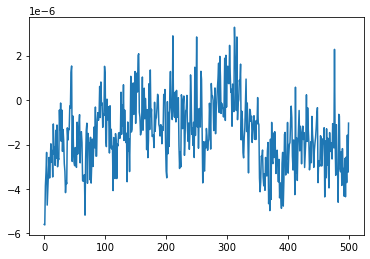

In [12]:
plt.plot(muons-muoffs)